In [2]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv('Bone_Tumor_Dataset_Expanded_200k.csv')

In [4]:
data.head

<bound method NDFrame.head of         Patient ID     Sex  Age         Grade  \
0       STS_000001  Female   64  Intermediate   
1       STS_000002    Male   52          High   
2       STS_000003    Male   27  Intermediate   
3       STS_000004    Male   56          High   
4       STS_000005  Female   62          High   
...            ...     ...  ...           ...   
199995  STS_199996  Female   30          High   
199996  STS_199997  Female   43  Intermediate   
199997  STS_199998    Male   56          High   
199998  STS_199999  Female   41  Intermediate   
199999  STS_200000    Male   70          High   

                             Histological type        MSKCC type  \
0                  pleiomorphic leiomyosarcoma               MFH   
1                  pleiomorphic leiomyosarcoma  Synovial sarcoma   
2                  pleiomorphic leiomyosarcoma    Leiomyosarcoma   
3             malignant solitary fibrous tumor    Leiomyosarcoma   
4          sclerosing epithelioid fibrosa

In [5]:
data.columns


Index(['Patient ID', 'Sex', 'Age', 'Grade', 'Histological type', 'MSKCC type',
       'Site of primary STS', 'Status (NED, AWD, D)', 'Treatment'],
      dtype='object')

In [8]:
data['Grade'].unique()

array(['Intermediate', 'High'], dtype=object)

In [9]:
data['Histological type'].unique()

array(['pleiomorphic leiomyosarcoma', 'malignant solitary fibrous tumor',
       'sclerosing epithelioid fibrosarcoma', 'myxoid fibrosarcoma',
       'undifferentiated - pleiomorphic', 'synovial sarcoma',
       'undifferentiated pleomorphic liposarcoma', 'epithelioid sarcoma',
       'poorly differentiated synovial sarcoma',
       'pleiomorphic spindle cell undifferentiated',
       'pleomorphic sarcoma', 'myxofibrosarcoma', 'leiomyosarcoma'],
      dtype=object)

In [10]:
data['MSKCC type'].unique()

array(['MFH', 'Synovial sarcoma', 'Leiomyosarcoma'], dtype=object)

In [11]:
data['Site of primary STS'].unique()

array(['left thigh', 'right thigh', 'right parascapusular', 'left biceps',
       'right buttock', 'parascapusular', 'left buttock'], dtype=object)

In [ ]:
data['Status (NED, AWD, D)'].unique()

array(['NED', 'D', 'AWD'], dtype=object)

In [14]:
data['Treatment'].unique()

array(['Radiotherapy + Surgery', 'Radiotherapy + Surgery + Chemotherapy',
       'Surgery + Chemotherapy'], dtype=object)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Reshape
import joblib

In [13]:
data = pd.read_csv('Bone Tumor Dataset.csv')

In [14]:
data.drop('Patient ID', axis=1, inplace=True)

In [15]:
target = 'Status (NED, AWD, D)'  # Changed to 'Status' column
features = data.drop(columns=[target])
target_data = data[target]

In [16]:
categorical_cols = ['Sex', 'Grade', 'Histological type', 'MSKCC type', 'Site of primary STS','Treatment']
features = pd.get_dummies(features, columns=categorical_cols)

In [17]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target_data)

In [18]:
scaler = StandardScaler()
features['Age'] = scaler.fit_transform(features[['Age']])

In [19]:
input_columns = features.columns
joblib.dump(input_columns, 'input_columns.pkl')

['input_columns.pkl']

In [20]:
# Prepare data for training
X = features.astype(np.float32).values
y = target_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Save label encoder for later use in Streamlit app
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [21]:
def build_simple_ann(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # For three classes
    ])
    return model

def build_deep_ann(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # For three classes
    ])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Reshape((input_shape, 1), input_shape=(input_shape,)),
        Conv1D(64, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # For three classes
    ])
    return model

def build_lstm(input_shape):
    model = Sequential([
        Reshape((input_shape, 1), input_shape=(input_shape,)),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # For three classes
    ])
    return model

In [22]:
models = {
    'Simple ANN1': build_simple_ann(X_train.shape[1]),
    'Deep ANN1': build_deep_ann(X_train.shape[1]),
    'CNN1': build_cnn(X_train.shape[1]),
    'LSTM1': build_lstm(X_train.shape[1])
}

c:\Users\04pnk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\04pnk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Train and save models
histories = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    histories[name] = history
    model.save(f"{name}_model.h5")  # Save each model
    preds = np.argmax(model.predict(X_test), axis=1)
    predictions[name] = preds




Training Simple ANN1...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3464 - loss: 1.0853 - val_accuracy: 0.6667 - val_loss: 0.9905
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6872 - loss: 0.9803 - val_accuracy: 0.6556 - val_loss: 0.9238
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7261 - loss: 0.8865 - val_accuracy: 0.6556 - val_loss: 0.8531
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7119 - loss: 0.8006 - val_accuracy: 0.6778 - val_loss: 0.7949
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7546 - loss: 0.7215 - val_accuracy: 0.7000 - val_loss: 0.7540
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7592 - loss: 0.6551 - val_accuracy: 0.7111 - val_loss: 0.7300
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7390 - loss: 0.6513 - val_accuracy: 0.7333 - val_loss: 0.7134
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7736 - loss: 0.6032 - val_a

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Training Deep ANN1...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4562 - loss: 1.0404 - val_accuracy: 0.4556 - val_loss: 0.9230
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5826 - loss: 0.8628 - val_accuracy: 0.6778 - val_loss: 0.8243
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6750 - loss: 0.7726 - val_accuracy: 0.7222 - val_loss: 0.7524
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7124 - loss: 0.7197 - val_accuracy: 0.7444 - val_loss: 0.7469
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7668 - loss: 0.6559 - val_accuracy: 0.7333 - val_loss: 0.7325
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7613 - loss: 0.5955 - val_accuracy: 0.7111 - val_loss: 0.7251
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7673 - loss: 0.6421 - val_accuracy: 0.7000 - val_loss: 0.7189
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - a

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Training CNN1...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3546 - loss: 1.0929 - val_accuracy: 0.4556 - val_loss: 1.0785
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4951 - loss: 1.0531 - val_accuracy: 0.4556 - val_loss: 1.0701
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5160 - loss: 1.0234 - val_accuracy: 0.4556 - val_loss: 1.0681
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5368 - loss: 0.9961 - val_accuracy: 0.4556 - val_loss: 1.0692
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5202 - loss: 0.9988 - val_accuracy: 0.4556 - val_loss: 1.0577
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5207 - loss: 0.9897 - val_accuracy: 0.4556 - val_loss: 1.0563
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5193 - loss: 0.9964 - val_accuracy: 0.4556 - val_loss: 1.0559
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy:

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025BF4C43B00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Training LSTM1...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4505 - loss: 1.0907 - val_accuracy: 0.4556 - val_loss: 1.0779
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4985 - loss: 1.0598 - val_accuracy: 0.4556 - val_loss: 1.0602
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4985 - loss: 1.0435 - val_accuracy: 0.4556 - val_loss: 1.0581
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4763 - loss: 1.0475 - val_accuracy: 0.4556 - val_loss: 1.0735
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4959 - loss: 1.0373 - val_accuracy: 0.4556 - val_loss: 1.0560
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5200 - loss: 1.0187 - val_accuracy: 0.4556 - val_loss: 1.0599
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5151 - loss: 1.0160 - val_accuracy: 0.4556 - val_loss: 1.0502
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - a

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step


In [24]:
# --- Confusion Matrix Plotting ---
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Simple ANN1 Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.50      0.50      0.50         8
           D       0.62      0.59      0.61        17
         NED       0.81      0.84      0.82        25

    accuracy                           0.70        50
   macro avg       0.64      0.64      0.64        50
weighted avg       0.70      0.70      0.70        50



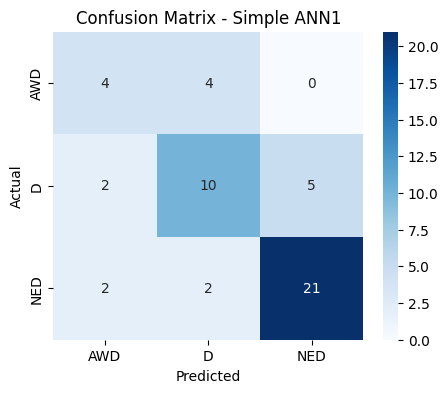


Deep ANN1 Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.44      0.50      0.47         8
           D       0.58      0.65      0.61        17
         NED       0.73      0.64      0.68        25

    accuracy                           0.62        50
   macro avg       0.58      0.60      0.59        50
weighted avg       0.63      0.62      0.62        50



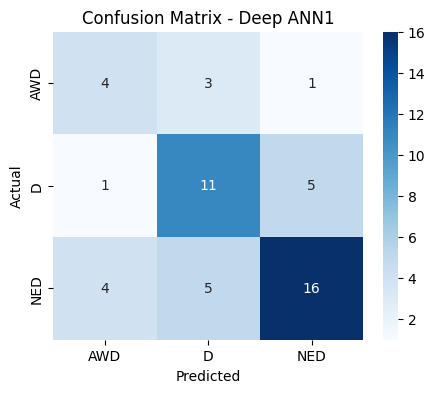


CNN1 Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.57      0.50      0.53         8
           D       0.80      0.24      0.36        17
         NED       0.63      0.96      0.76        25

    accuracy                           0.64        50
   macro avg       0.67      0.57      0.55        50
weighted avg       0.68      0.64      0.59        50



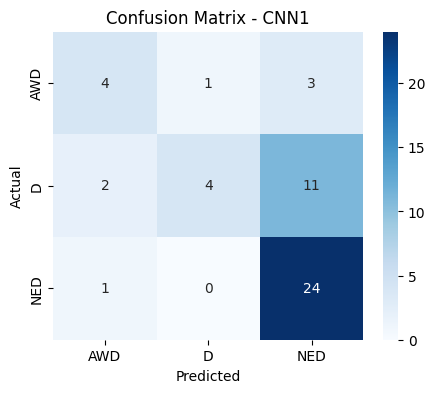


LSTM1 Model Classification Report:

              precision    recall  f1-score   support

         AWD       0.62      0.62      0.62         8
           D       0.67      0.71      0.69        17
         NED       0.83      0.80      0.82        25

    accuracy                           0.74        50
   macro avg       0.71      0.71      0.71        50
weighted avg       0.74      0.74      0.74        50



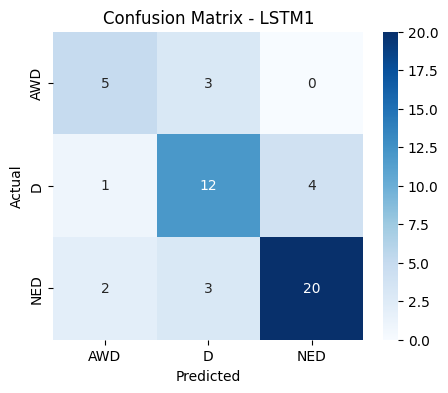

Evaluating Simple ANN1 model on test data:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.7063 - loss: 0.8093  
Test loss: 0.8171939253807068, Test accuracy: 0.699999988079071
Evaluating Deep ANN1 model on test data:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6217 - loss: 1.3093 
Test loss: 1.3232954740524292, Test accuracy: 0.6200000047683716
Evaluating CNN1 model on test data:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.6454 - loss: 0.9215  
Test loss: 0.9572594165802002, Test accuracy: 0.6399999856948853
Evaluating LSTM1 model on test data:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7329 - loss: 0.7949
Test loss: 0.7958942651748657, Test accuracy: 0.7400000095367432


In [25]:
for name, preds in predictions.items():
    print(f"\n{name} Model Classification Report:\n")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))
    plot_confusion(y_test, preds, name)

# Final model evaluation (optional)
for name, model in models.items():
    print(f"Evaluating {name} model on test data:")
    evaluation = model.evaluate(X_test, y_test)
    print(f"Test loss: {evaluation[0]}, Test accuracy: {evaluation[1]}")